In [2]:
from ultralytics import YOLO
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Processing: POSDISP_[4]_0001_002.ima

0: 320x320 1 L5/S1, 1 L4/L5, 1 L3/L4, 1 L2/L3, 1 L1/L2, 12.8ms
Speed: 0.7ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 320)


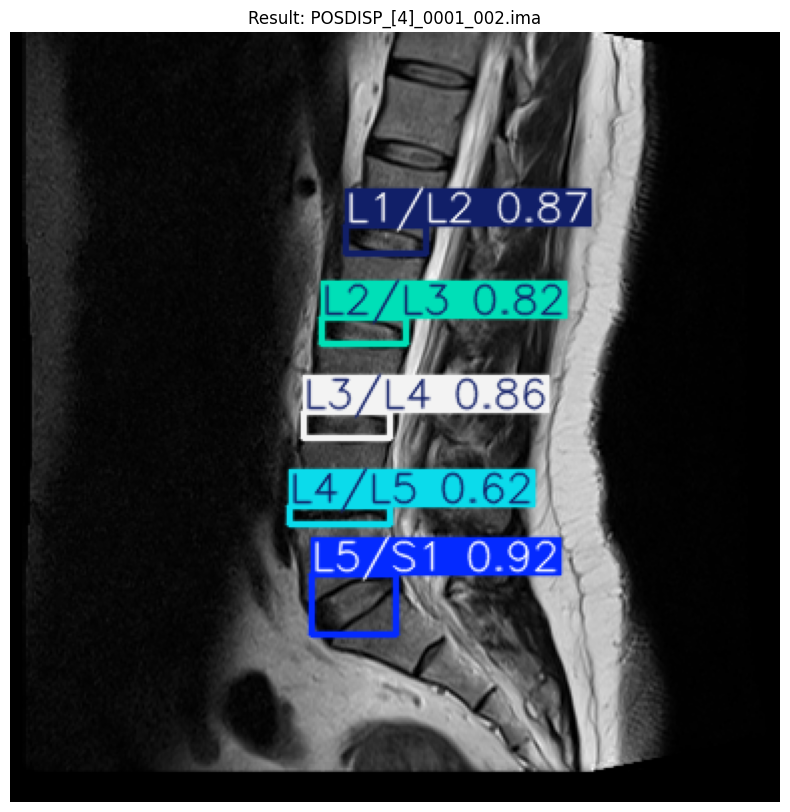

Found: L5/S1 (Confidence: 0.92)
Found: L1/L2 (Confidence: 0.87)
Found: L3/L4 (Confidence: 0.86)
Found: L2/L3 (Confidence: 0.82)
Found: L4/L5 (Confidence: 0.62)
Processing: T2_TSE_SAG__0004_006.ima

0: 320x320 1 L5/S1, 1 L4/L5, 1 L3/L4, 1 L2/L3, 1 L1/L2, 9.2ms
Speed: 0.5ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


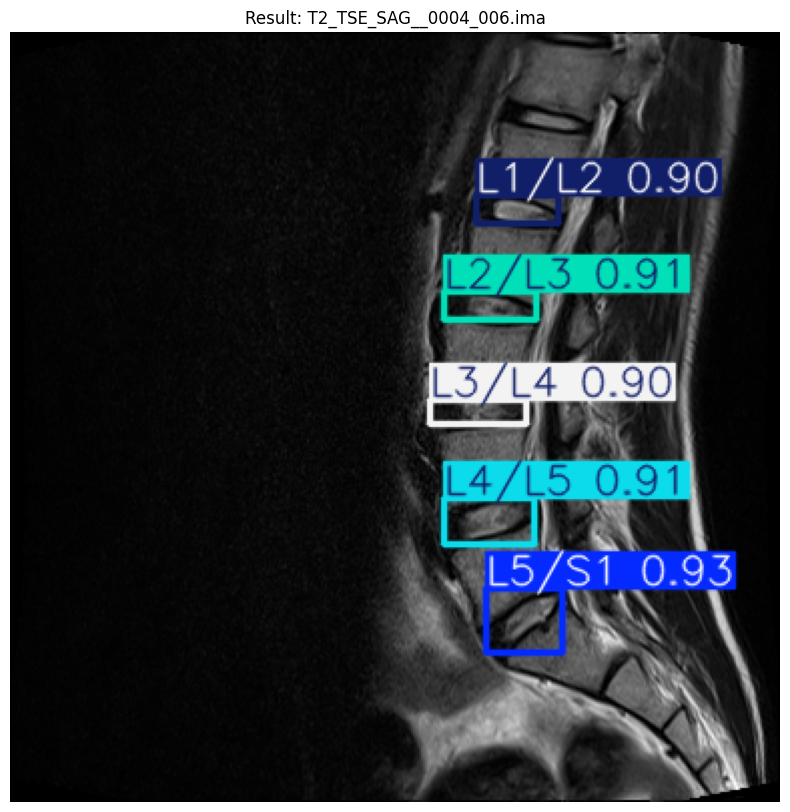

Found: L5/S1 (Confidence: 0.93)
Found: L2/L3 (Confidence: 0.91)
Found: L4/L5 (Confidence: 0.91)
Found: L1/L2 (Confidence: 0.90)
Found: L3/L4 (Confidence: 0.90)
Processing: POSDISP_[5]_0010_001.ima

0: 320x320 (no detections), 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 0.2ms postprocess per image at shape (1, 3, 320, 320)


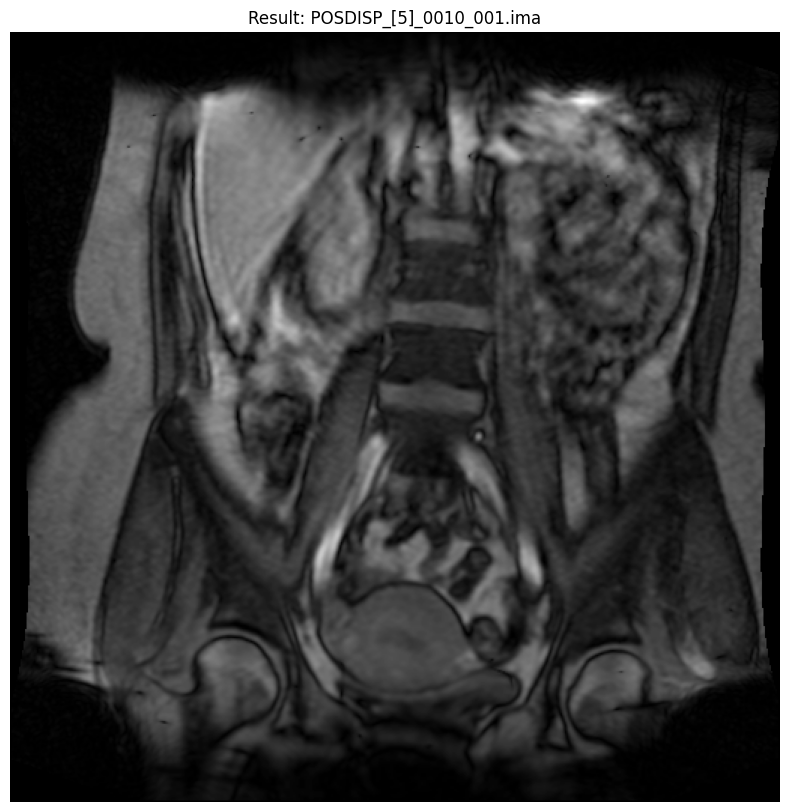

No discs detected.
Processing: T2_TSE_SAG__0160_011.ima

0: 320x320 1 L5/S1, 1 L4/L5, 1 L3/L4, 1 L2/L3, 1 L1/L2, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


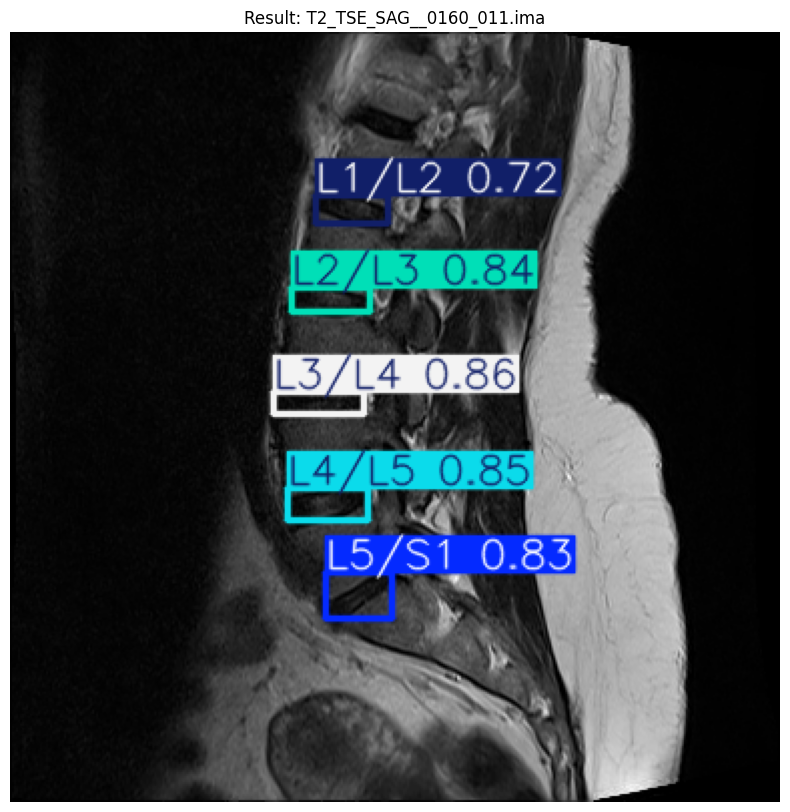

Found: L3/L4 (Confidence: 0.86)
Found: L4/L5 (Confidence: 0.85)
Found: L2/L3 (Confidence: 0.84)
Found: L5/S1 (Confidence: 0.83)
Found: L1/L2 (Confidence: 0.72)


In [5]:
model_path = 'runs/detect/disc_location/weights/best.pt'

paths_to_test = [
    'Mendeley/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_002.ima',
    'Mendeley/0004/L-SPINE_CLINICAL_LIBRARIES_20160526_115018_014000/T2_TSE_SAG_384_0002/T2_TSE_SAG__0004_006.ima',
    'Mendeley/0010/L-SPINE_CLINICAL_LIBRARIES_20160503_120112_052000/POSDISP_[5]_T1_TSE_TRA_5001/POSDISP_[5]_0010_001.ima',
    'Mendeley/0160/L-SPINE_LSS_20150927_130210_724000/T2_TSE_SAG_384_0003/T2_TSE_SAG__0160_011.ima'  
]

def predict_dicom(image_list, model_file):
    if not os.path.exists(model_file):
        print(f"Model not found at: {model_file}")
        return

    model = YOLO(model_file)

    for img_path in image_list:
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue

        print(f"Processing: {os.path.basename(img_path)}")

        try:
            sitk_img = sitk.ReadImage(img_path)
            arr = sitk.GetArrayFromImage(sitk_img)
            arr = np.squeeze(arr)

            img_min = np.min(arr)
            img_max = np.max(arr)

            if img_max == img_min:
                img_uint8 = np.zeros_like(arr, dtype=np.uint8)
            else:
                img_norm = 255.0 * (arr - img_min) / (img_max - img_min)
                img_uint8 = img_norm.astype(np.uint8)

            img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)

            results = model.predict(img_rgb, conf=0.25)
            
            result_plot = results[0].plot()
            result_final = cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 10))
            plt.imshow(result_final)
            plt.title(f"Result: {os.path.basename(img_path)}")
            plt.axis('off')
            plt.show()

            for box in results[0].boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                label = results[0].names[cls_id]
                print(f"Found: {label} (Confidence: {conf:.2f})")
            
            if not results[0].boxes:
                print("No discs detected.")

        except Exception as e:
            print(f"Error processing image: {e}")

predict_dicom(paths_to_test, model_path)